In [1]:
from copy import deepcopy
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def graph_progress(all_costs, all_accuracies, show_recents=True):
    # last 5 results
    # ---------------
    if show_recents:
        line1 = "cost: "
        line2 = "acc:  "
        if len(all_costs) < 5: show = len(all_costs)
        else:                  show = 5
        for i in range(-show, 0):
            line1 += "{:>8} ".format(round(all_costs[i], 5))
            line2 += "{:>8}%".format(round(all_accuracies[i]*100, 2))
        print(line1)
        print(line2)


    # graphs
    # -------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(range(len(all_costs)), all_costs, label="costs")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('cost') # Set a title of the current axes.
    axes[0].set_title('cost over training steps') 
    axes[0].legend() # show a legend on the plot

    axes[1].plot(range(len(all_accuracies)), all_accuracies, label="accuracies")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('accuracy') # Set a title of the current axes.
    axes[1].set_title('accuracy over training steps') 
    axes[1].legend() # show a legend on the plot

    return fig.tight_layout()

# import training data

In [3]:
import pandas as pd #1
import os           #3

In [4]:
given_data_folder = 'prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_training_data.csv',
 'M_training_data_embedding.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_training_data.csv',
 'predictions']

In [5]:
training_data_file = 'M_training_data_embedding.csv'

In [6]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

46338


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a,solution
0,11872022.0,14412022.0,0.750000,0.633800,0.787037,0.439078,0.680556,0.750842,0.662162,0.605263,...,-0.567568,-0.605263,-0.675676,-0.479167,-0.659091,-0.538462,-0.500000,-0.621212,-0.847291,1
1,14412022.0,11872022.0,0.754902,0.658602,0.555556,0.582219,0.930556,0.601307,0.594595,0.578947,...,-0.675676,-0.578947,-0.770270,-0.354167,-0.659091,-0.807692,-0.375000,-0.606061,-0.400841,-1
2,12522022.0,12592022.0,0.833333,0.763211,0.648148,0.694010,0.555556,0.798333,0.662162,0.236842,...,-0.567568,-0.657895,-0.635135,-0.687500,-0.454545,-0.615385,-0.500000,-0.606061,-0.768758,1
3,12592022.0,12522022.0,0.699346,0.750538,0.629630,0.404228,0.712963,0.706472,0.513513,0.280702,...,-0.675676,-0.543860,-0.702703,-0.569444,-0.666667,-0.615385,-0.458333,-0.545455,-0.541014,-1
4,13292022.0,13412022.0,0.700980,0.737634,0.750000,0.435882,0.583333,0.632353,0.391892,0.684211,...,-0.297297,-0.394737,-0.567568,-0.312500,-0.863636,-0.538462,-0.562500,-0.439394,-0.598615,1


## get as rows

In [7]:
# wether or not to keep the data for stats against a team
keep_against = True

In [8]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)
    

    
# indicis
# 30 each 0:15, 15:30, 30:45, 45:60
if not keep_against:
    new_training_columns = training_columns[0:15] + training_columns[30:45] + [training_columns[60]]
    training_columns = new_training_columns
    
    
    
# get as rows
training_input_rows    = []
training_solution_rows = []
embedding_key_rows     = []
for i in range(len(training_columns[0])):
    new_input_row         = []
    new_solution_row      = [training_columns[-1][i]]
    new_embedding_key_row = [int(training_columns[0][i]), int(training_columns[1][i])]
    for j in range(2, len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    embedding_key_rows    .append(new_embedding_key_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))
print(len(embedding_key_rows), len(embedding_key_rows[0]))

46338 114
46338 1
46338 2


In [371]:
#split = 7_000
#np_inputs    = np.array(training_input_rows[:split])
#np_solutions = np.array(training_solution_rows[:split])

#embedding_key_rows = embedding_key_rows[:split]

np_inputs    = np.array(training_input_rows)
np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

# My Custom Graphing Setup

In [81]:
import matplotlib.pyplot as plt

In [226]:
def progress_graph(graph_history, start_at=0):
    # data for graphs
    # ----------------
    loss = graph_history["loss"][start_at:]
    mse = graph_history["mse"][start_at:]
    binary_accuracy = graph_history["binary_accuracy"][start_at:]
    
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Binary Cross Entropy
    # ---------------------
    axes[0].plot(range(len(loss)), loss, label="loss")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('loss') # Set a title of the current axes.
    axes[0].set_title('loss over training steps') 
    axes[0].legend() # show a legend on the plot

    
    # Mean Squared Error
    # -------------------
    axes[1].plot(range(len(mse)), mse, label="mse")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('mse') # Set a title of the current axes.
    axes[1].set_title('mse over training steps') 
    axes[1].legend() # show a legend on the plot
    
    
    # Binary Accuracy
    # ----------------
    axes[2].plot(range(len(binary_accuracy)), binary_accuracy, label="accuracies")
    axes[2].set_xlabel('step') # Set the y axis label of the current axis.
    axes[2].set_ylabel('accuracy') # Set a title of the current axes.
    axes[2].set_title('accuracy over training steps') 
    axes[2].legend() # show a legend on the plot

    
    return fig.tight_layout()

# Create and Train population

In [14]:
#!pip install tensorflow

In [16]:
import tensorflow as tf

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-03-13 00:07:20.692785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [372]:
np_solutions = np.divide(np.add(np_solutions, 1), 2)

In [373]:
print(np_inputs.shape)
print(np_solutions.shape)

(46338, 114)
(46338, 1)


In [374]:
print(int(114*5/2))

285


In [375]:
inner_activations = 'tanh'
inner_size = 285

In [376]:
# define the keras model
model = Sequential()
model.add(Dense(inner_size, input_shape=(114,), activation=inner_activations))
model.add(Dense(inner_size, activation=inner_activations)) # 1
model.add(Dense(inner_size, activation=inner_activations)) # 2
model.add(Dense(inner_size, activation=inner_activations)) # 3 --
model.add(Dense(inner_size, activation=inner_activations)) # 4
#model.add(Dense(inner_size, activation=inner_activations)) # 5
#model.add(Dense(inner_size, activation=inner_activations)) # 6
#model.add(Dense(inner_size, activation=inner_activations)) # 7
#model.add(Dense(inner_size, activation=inner_activations)) # 8
model.add(Dense(1, activation='linear'))

In [377]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss='mse',
              metrics=[tf.keras.metrics.BinaryAccuracy(), 'mse'])

In [378]:
graph_history = {"loss": [], "mse": [], "binary_accuracy": []}

In [379]:
# This builds the model for the first time:
#model.fit(np_inputs, np_solutions, batch_size=10, epochs=30)
history = model.fit(np_inputs, np_solutions, validation_split=0.30, 
          epochs=1800, 
          batch_size=100,
          verbose=0)

graph_history["loss"] += history.history['val_loss']
graph_history["mse"] += history.history['val_mse']
graph_history["binary_accuracy"] += history.history['val_binary_accuracy']

print("LOSS:    ", history.history['val_loss'][-5:])
print("ACCURACY:", history.history['val_binary_accuracy'][-5:])

LOSS:     [0.1987176537513733, 0.1986670047044754, 0.19855429232120514, 0.1986338049173355, 0.1985148787498474]
ACCURACY: [0.6924183368682861, 0.6926341652870178, 0.6930657625198364, 0.6934254169464111, 0.693641185760498]


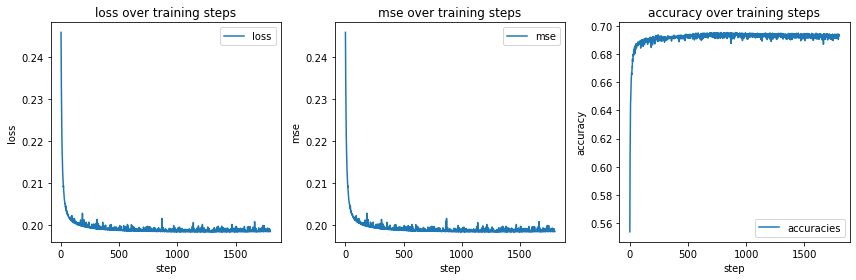

In [380]:
progress_graph(graph_history, start_at=0)

In [364]:
'''
900 steps, 285, 4 layers, tanh, 1e-6
LOSS:     [0.20348791778087616, 0.2044401615858078, 0.2037125676870346, 0.2039404809474945, 0.204872727394104]
ACCURACY: [0.691428542137146, 0.689047634601593, 0.6866666674613953, 0.6857143044471741, 0.6819047331809998]

900 steps, 285, 5 layers, tanh, 1e-6
LOSS:     [0.20485517382621765, 0.20482157170772552, 0.2048875093460083, 0.20482952892780304, 0.20482312142848969]
ACCURACY: [0.6823809742927551, 0.6819047331809998, 0.6809523701667786, 0.6828571557998657, 0.6857143044471741]

900 steps, 114, 8 layers, tanh, 1e-6
LOSS:     [0.21138890087604523, 0.21108748018741608, 0.21135681867599487, 0.21115154027938843, 0.2110992968082428]
ACCURACY: [0.6619047522544861, 0.6676190495491028, 0.6604762077331543, 0.6628571152687073, 0.6638095378875732]




900 steps, 114, 5 layers, tanh, 5e-7
LOSS:     [0.21519961953163147, 0.2151254117488861, 0.21521975100040436, 0.21517185866832733, 0.21519938111305237]
ACCURACY: [0.6580952405929565, 0.6595237851142883, 0.6590476036071777, 0.657619059085846, 0.6580952405929565]
1800 steps, 114, 5 layers, tanh, 5e-7
LOSS:     [0.21039246022701263, 0.21049287915229797, 0.21038582921028137, 0.21027831733226776, 0.2105008065700531]
ACCURACY: [0.6752380728721619, 0.6747618913650513, 0.6752380728721619, 0.677142858505249, 0.6747618913650513]
2700 steps, 114, 5 layers, tanh, 5e-7
LOSS:     [0.20813001692295074, 0.20821788907051086, 0.2081948220729828, 0.20820313692092896, 0.20820526778697968]
ACCURACY: [0.6838095188140869, 0.6838095188140869, 0.6828571557998657, 0.6833333373069763, 0.6833333373069763]
3600 steps, 114, 5 layers, tanh, 5e-7
LOSS:     [0.20722869038581848, 0.20715150237083435, 0.20715796947479248, 0.20718446373939514, 0.20714379847049713]
ACCURACY: [0.6790476441383362, 0.6838095188140869, 0.6819047331809998, 0.6809523701667786, 0.6838095188140869]




900 steps, 114, 4 layers, tanh, 1e-6
LOSS:     [0.20626215636730194, 0.2062297761440277, 0.2062915861606598, 0.206207275390625, 0.20624925196170807]
ACCURACY: [0.6838095188140869, 0.6838095188140869, 0.6842857003211975, 0.6833333373069763, 0.6833333373069763]
900 steps, 114, 5 layers, tanh, 1e-6
LOSS:     [0.20984473824501038, 0.21001917123794556, 0.20971661806106567, 0.21001145243644714, 0.2095995396375656]
ACCURACY: [0.6647619009017944, 0.6676190495491028, 0.6647619009017944, 0.6671428680419922, 0.6642857193946838]



900 steps, 285, 4 layers, relu, 1e-6
LOSS:     [0.20740726590156555, 0.20726948976516724, 0.2073499858379364, 0.20787569880485535, 0.20728017389774323]
ACCURACY: [0.6742857098579407, 0.6752380728721619, 0.6733333468437195, 0.680476188659668, 0.6761904954910278]
900 steps, 114, 4 layers, relu, 1e-6
LOSS:     [0.2093418538570404, 0.20932115614414215, 0.20932385325431824, 0.2093067616224289, 0.209292471408844]
ACCURACY: [0.6757143139839172, 0.677142858505249, 0.6766666769981384, 0.677142858505249, 0.677142858505249]
''';

In [ ]:
#result = model.evaluate(test_dataset)

In [79]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [54]:
# compile the keras model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='mse')
#model.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='sgd', 
              metrics=['accuracy'])


In [ ]:
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))